In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sovitrath/diabetic-retinopathy-224x224-gaussian-filtered")

print("Path to dataset files:", path)

100%|██████████| 427M/427M [00:05<00:00, 86.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sovitrath/diabetic-retinopathy-224x224-gaussian-filtered/versions/2


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
main_folder_path = os.path.join(path, "gaussian_filtered_images", "gaussian_filtered_images")

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 255
CHANNEL = 3
EPOCHS = 20

In [ ]:
import tensorflow as tf
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=main_folder_path,
    seed=123,
    shuffle=True,
    image_size=(255, 255),
    batch_size=32,
)


Found 3662 files belonging to 5 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

In [ ]:
def get_dataset_partitions_(dataset,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
  assert (train_split+val_split+test_split)==1

  ds_size = len(dataset)

  if shuffle:
    dataset = dataset.shuffle(shuffle_size,seed=12)
  train_size = int(train_split*ds_size)
  val_size = int(val_split*ds_size)

  train_ds = dataset.take(train_size)
  val_ds = dataset.skip(train_size).take(val_size)
  test_ds = dataset.skip(train_size).skip(val_size)

  return train_ds,val_ds,test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_(dataset)

In [ ]:
len(train_ds)

92

In [ ]:
len(val_ds)

11

In [ ]:
len(test_ds)

12

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [ ]:
input_shape = (255,255,3)  # Single image shape
n_classes = 5

model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=input_shape),  # Input layer for single image
    resize_and_rescale,  # Preprocessing: resize and normalize

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 255, 255, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 253, 253, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 251, 251, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 125, 125, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 123, 123, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 121, 121, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 60, 60, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 58, 58, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       6,422,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,709,925 (25.60 MB)

 Trainable params: 6,709,925 (25.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=10,          # Number of epochs with no improvement after which training will stop
    verbose=1,           # Prints messages when stopping is triggered
    restore_best_weights=True  # Restores the model weights from the epoch with the best value of the monitored metric
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 66s 424ms/step - accuracy: 0.5417 - loss: 1.2941 - val_accuracy: 0.6932 - val_loss: 0.8510
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 0.6997 - loss: 0.8545 - val_accuracy: 0.7244 - val_loss: 0.7880
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 148ms/step - accuracy: 0.7231 - loss: 0.7760 - val_accuracy: 0.7500 - val_loss: 0.7321
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step - accuracy: 0.7305 - loss: 0.7320 - val_accuracy: 0.7727 - val_loss: 0.6987
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.7511 - loss: 0.6777 - val_accuracy: 0.8153 - val_loss: 0.5475
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.7989 - loss: 0.5637 - val_accuracy: 0.8409 - val_loss: 0.4922
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - accuracy: 0.8234 - loss: 0.4833 - val_accuracy: 0.8722 - val_loss: 0.4195
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - accuracy: 0.8601 - loss: 0.3520 - val_accu

In [ ]:
model.save('model.h5')


In [ ]:
from google.colab import files
files.download('model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

First image to predict
Actual label No_DR


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
Predicted label No_DR


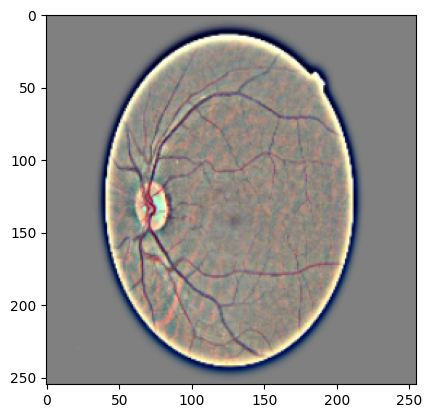

In [ ]:
import tensorflow as tf
import numpy as np
model = tf.keras.models.load_model('model.h5')

for batch_size, label_name in test_ds.take(1):
  img = batch_size[8].numpy().astype('uint8')
  label = label_name[8].numpy()
  print("First image to predict")
  plt.imshow(img)
  print("Actual label",class_names[label])

  batch_prediction = model.predict(batch_size)
  print("Predicted label",class_names[np.argmax(batch_prediction[8])])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import load_model

model_path = "/content/drive/MyDrive/Colab Notebooks/final_model.h5"  # Update this path as needed
model = load_model(model_path)
print("Model loaded successfully!")


Model loaded successfully!


In [ ]:
import tensorflow as tf
import numpy as np
img = 'Healthy.png'
img = tf.keras.preprocessing.image.load_img(img, target_size=(255, 255))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)

predicted_class = class_names[np.argmax(predictions[0])]
confidence = round(100 * (np.max(predictions[0])), 2)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [ ]:
predicted_class

'No_DR'